# <font color=#004090>LOAN DEFAULT PREDICTION</font>
-----
## Machine Learning Engineer Nanodegree<br>Capstone Project Notebook
Ricardo Szczerbacki <br>
October 2019

This is the work notebook where the models where implemented and evaluated.




In [1]:
import os
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)


In [2]:
outputdir = 'data'
start_log_datetime = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
log_path = ""
logfilename = ""

def startLog():
    global log_path
    global logfilename
    
    start_log_datetime = datetime.datetime.now().strftime("%Y-%m-%d_%H_%M_%S")
    log_path = os.path.join(outputdir, start_log_datetime)
    logfilename = os.path.join(log_path,'process.txt')

    if not (os.path.isdir(log_path)):
        os.mkdir(os.path.join(os.getcwd(), log_path))
        open(logfilename, 'a+').close()

def log(*args, **kwargs):
    print(*args, **kwargs)
    
    output_file = open(logfilename, 'a')
    print(*args, **kwargs, file=output_file)


In [3]:
def dumpToFile(obj, filename):
    file = open(os.path.join('data',filename),"wb")
    pickle.dump(obj,file)
    file.close()
    
def loadFromFile(filename):
    file = open(os.path.join('data',filename),"rb")
    data = pickle.load(file)
    file.close()
    
    return data
    

In [4]:
train_data = pd.read_pickle('data/processed_data')
train_data.head()

,TARGET,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,APPROVED_COUNT,REFUSED_COUNT,DIFF_APPROVED_REFUSED,AMT_INSTALMENT_MAX,AMT_INSTALMENT_MEAN,AMT_PAYMENT_MAX,AMT_PAYMENT_MEAN,DIFF_INST_PAYMENT_MAX,DIFF_INST_PAYMENT_MEAN,DEBIT_TO_INCOME
0,1,0,1,0.0,0.245235,0.489168,0.537543,0.468926,0.256321,0.888839,...,0.000000,0.02165,0.089919,0.014078,0.004615,0.014078,0.004615,0.020545,0.000000,0.015549
1,0,0,0,0.0,0.279379,0.746353,0.610134,0.722716,0.045016,0.477114,...,0.076923,0.02165,0.089919,0.148704,0.025854,0.148704,0.025854,0.020545,0.000000,0.014825
2,0,1,1,0.0,0.114842,0.244146,0.281841,0.261439,0.134897,0.348534,...,0.000000,0.02165,0.089919,0.002804,0.002833,0.002804,0.002833,0.020545,0.000000,0.014825
3,0,0,1,0.0,0.197110,0.430802,0.573785,0.432651,0.107023,0.350846,...,0.153846,0.00000,0.153846,0.183425,0.025133,0.183425,0.025133,0.020545,0.000000,0.014825
4,0,0,1,0.0,0.184605,0.540826,0.513513,0.551331,0.392880,0.298591,...,0.192308,0.02165,0.089919,0.006013,0.005057,0.006013,0.004877,0.029697,0.000935,0.014825


In [11]:
# Separate approximately 10% of the training set to hyperparameters tuning
y = train_data['TARGET']
X = train_data.drop('TARGET', axis=1)

X, X_tuning, y, y_tuning = train_test_split(X, y, test_size=.10, random_state=42)

print("Shape of the original train dataset: {}".format(train_data.shape))
print("Shape of the tuning subset of the train dataset: {}".format(X.shape))
print("Shape of the remaining train dataset: {}".format(X_tuning.shape))


Shape of the original train dataset: (302054, 308)
Shape of the tuning subset of the train dataset: (271848, 307)
Shape of the remaining train dataset: (30206, 307)


### Feature Ranking
In this step I will use a tree classifier to obtain the estimated importance of the features, so we can make a ranking and evaluate all our models with different number of features.


In [12]:
if (os.path.exists('data/importances') and os.path.exists('data/indices')):
    importances = np.load('data/importances', allow_pickle=True)
    indices = np.load('data/indices', allow_pickle=True)
else:
    tree_classifier = ExtraTreesClassifier(n_estimators=250, random_state=0)
    tree_classifier.fit(X, y)
    importances = tree_classifier.feature_importances_
    indices = np.argsort(importances)[::-1]
    importances.dump('data/importances')
    indices.dump('data/indices')

In [13]:
print("FEATURE RANKING")
print()
print("Pos Feature                        Importance")
print("---------------------------------------------------------------")

for i in range(X.shape[1]):
    print("{:03d} {:30} {}".format(i+1, X.columns[indices[i]], importances[indices[i]]))

FEATURE RANKING

Pos Feature                        Importance
---------------------------------------------------------------
001 EXT_SOURCE_2                   0.021780562861958903
002 EXT_SOURCE_3                   0.020207222767413355
003 DAYS_BIRTH                     0.010679916639200393
004 EXT_SOURCE_1                   0.01039131957682519
005 CNT_INSTALMENT_FUTURE_MEAN     0.010119667809326188
006 DAYS_ID_PUBLISH                0.010032990541482736
007 DAYS_LAST_PHONE_CHANGE         0.009769291871930846
008 DAYS_REGISTRATION              0.009596356829694884
009 CNT_INSTALMENT_MEAN            0.009457888456776703
010 HOUR_APPR_PROCESS_START        0.009451960108060804
011 AMT_INCOME_TOTAL               0.00937869493762779
012 DIFF_APPROVED_REFUSED          0.00922300524215831
013 REFUSED_COUNT                  0.009158518169210407
014 REGION_POPULATION_RELATIVE     0.009155577610998505
015 AMT_CREDIT                     0.009021422662603059
016 AMT_ANNUITY                    0

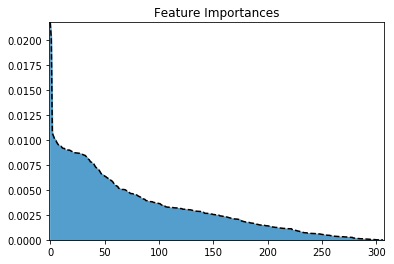

In [14]:
plt.figure()
plt.title("Feature Importances")
plt.plot(range(X.shape[1]), importances[indices],'k--')
plt.fill_between(range(X.shape[1]), importances[indices], color='#539ecd')
plt.xlim([-1, X.shape[1]])
plt.ylim([0, np.amax(importances)])

plt.show()

## Hyperparameters Tuning
Here I will use the Randomized Search implementation of the sklearn to optimize the hyperparameter for the Random Trees and the XGBoost models.

In [15]:
startLog()

In [16]:
# Random Search for the Random Forest Classifier
if (os.path.exists('data/rf_params.dat')):
    rf_params = loadFromFile('rf_params.dat')
else:
    rf_grid = {'max_depth': [10, 50, 100, None],
               'min_samples_leaf': [1, 2, 4],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [20, 100, 200, 500]}


    # Use only 10% of the data for better performance
    log("Random Search for the Random Forest Classifier")
    log("------------------------------------------------")
    pre_train_time = time.time()

    random_forest = RandomForestClassifier()
    rf_random = RandomizedSearchCV(estimator = random_forest, param_distributions = rf_grid, n_iter = 100, cv = 3, verbose=10, random_state=42, n_jobs = -1, scoring='roc_auc')
    rf_random.fit(X_tuning, y_tuning)

    log("Time: " + str(time.time() - pre_train_time) + " sec")
    log("Best score: " + str(rf_random.best_score_))
    log("Best estimator:")
    log(rf_random.best_estimator_.get_params())
    rf_params = rf_random.best_estimator_.get_params()
    dumpToFile(rf_params, 'rf_params.dat')





Random Search for the Random Forest Classifier
------------------------------------------------
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   52.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 19

Time: 2068.9070041179657 sec
Best score: 0.7375722238665305
Best estimator:
{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [17]:
# Random Search for the XGBoost Classifier
if (os.path.exists('data/xgb_params.dat')):
    xgb_params = loadFromFile('xgb_params.dat')
else:
    xgboost_grid = {'silent': [False],
                    'max_depth': [6, 10, 20],
                    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
                    'subsample': [0.5, 0.8, 1.0],
                    'colsample_bytree': [0.4, 0.7, 1.0],
                    'colsample_bylevel': [0.4, 0.7, 1.0],
                    'min_child_weight': [0.5, 3.0, 5.0, 10.0],
                    'gamma': [0, 0.25, 0.5, 1.0],
                    'reg_lambda': [0.1, 1.0, 10.0, 50.0, 100.0],
                    'n_estimators': [20, 50, 100]}
    log("")
    log("Random Search for the XGBoost Classifier")
    log("------------------------------------------------")
    pre_train_time = time.time()

    xgboost_classifier = XGBClassifier()
    xgb_random = RandomizedSearchCV(estimator = xgboost_classifier, param_distributions = xgboost_grid, n_iter = 100, cv = 3, verbose=10, random_state=42, n_jobs = -1, scoring='roc_auc')
    xgb_random.fit(X_tuning, y_tuning)

    log("Time: " + str(time.time() - pre_train_time) + " sec")
    log("Best score: " + str(xgb_random.best_score_))
    log("Best estimator:")
    log(xgb_random.best_estimator_.get_params())
    xgb_params = xgb_random.best_estimator_.get_params()
    dumpToFile(xgb_params, 'xgb_params.dat')


Random Search for the XGBoost Classifier
------------------------------------------------
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 11

Time: 1302.6115396022797 sec
Best score: 0.7524861478834752
Best estimator:
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 1, 'colsample_bytree': 1.0, 'gamma': 0.25, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 10.0, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 100.0, 'scale_pos_weight': 1, 'seed': None, 'silent': False, 'subsample': 1.0, 'verbosity': 1}


## Models Evaluation

Now, with a ranking of the features and the optimized hyperparameters we can evalute the models increasing gradually the number of features used, so we can decide the number of features to be used in the final solution.

In [18]:
start_time = time.time()

# Classifiers
# For the Random Prediction implementation I will use the Sci-kit Learn DummyClassifier.
baseline = DummyClassifier(strategy='uniform', random_state=42)
logistic_regression = LogisticRegression(solver='saga', max_iter=4000)
random_forest = RandomForestClassifier()
random_forest.set_params(**rf_params)
xgboost_classifier = XGBClassifier()
xgboost_classifier.set_params(**xgb_params)

baseline_best_score = -1000.
lr_best_score = -1000.
rf_best_score = -1000.
xgb_best_score = -1000.

baseline_scores = list(range(10)) 
baseline_training_times = list(range(10)) 
lr_scores = list(range(10)) 
lr_training_times = list(range(10)) 
rf_scores = list(range(10)) 
rf_training_times = list(range(10)) 
xgb_scores = list(range(10)) 
xgb_training_times = list(range(10)) 


# Percent of the number features to increase at each iteration
steps = 10
#total_number_of_features = len(X.columns)
total_number_of_features = int(len(X.columns) / 2) # use only half of the features and check if it is enough
now = datetime.datetime.now()
log(now.strftime("%Y-%m-%d %H:%M:%S"))
for i in range(0, steps):
    iteration_time = time.time()

    last_feature_ind = int(np.ceil((total_number_of_features * ((i+1) * steps))/100.))
    selected_features = X.columns[indices[:last_feature_ind]]
    Xs = X[selected_features]

    log("First {} features".format(last_feature_ind))
    log("----------------------------------")
    
    inner_cv = KFold(n_splits=10, shuffle=True, random_state=42)
    outer_cv = KFold(n_splits=10, shuffle=True, random_state=42)
    
    # Baseline
    pre_train_time = time.time()
    baseline_scores[i] = cross_val_score(baseline, Xs, y, cv=outer_cv, scoring='roc_auc')
    baseline_training_times[i] = time.time() - pre_train_time
    log("Random Classifier (baseline) CV score: mean: {:.5f}, min: {:.5f}, max: {:.5f}, std: {:.5f} (time {:.1f} secs)"
          .format(baseline_scores[i].mean(), baseline_scores[i].min(), 
                  baseline_scores[i].max(), baseline_scores[i].std(),
                  baseline_training_times[i]))
    if baseline_scores[i].mean() > baseline_best_score:
        baseline_best_score = baseline_scores[i].mean()
        baseline_best_iteration = i
    
    # Logistic Regression
    pre_train_time = time.time()
    lr_scores[i] = cross_val_score(logistic_regression, Xs, y, cv=outer_cv, scoring='roc_auc')
    lr_training_times[i] = time.time() - pre_train_time
    log("Logistic Regression Classifier CV score: mean: {:.5f}, min: {:.5f}, max: {:.5f}, std: {:.5f} (time {:.1f} secs)"
          .format(lr_scores[i].mean(), lr_scores[i].min(), 
                  lr_scores[i].max(), lr_scores[i].std(),
                  lr_training_times[i]))
    if lr_scores[i].mean() > lr_best_score:
        lr_best_score = lr_scores[i].mean()
        lr_best_iteration = i
    
    # Random Forest
    pre_train_time = time.time()
    rf_scores[i] = cross_val_score(random_forest, Xs, y, cv=outer_cv, scoring='roc_auc')
    rf_training_times[i] = time.time() - pre_train_time
    log("Random Forest Classifier CV score: mean: {:.5f}, min: {:.5f}, max: {:.5f}, std: {:.5f} (time {:.1f} secs)"
          .format(rf_scores[i].mean(), rf_scores[i].min(), 
                  rf_scores[i].max(), rf_scores[i].std(),
                  rf_training_times[i]))
    if rf_scores[i].mean() > rf_best_score:
        rf_best_score = rf_scores[i].mean()
        rf_best_iteration = i
    
    # XGBoost
    pre_train_time = time.time()
    xgb_scores[i] = cross_val_score(xgboost_classifier, Xs, y, cv=outer_cv, scoring='roc_auc')
    xgb_training_times[i] = time.time() - pre_train_time
    log("XGBoost Classifier CV score: mean: {:.5f}, min: {:.5f}, max: {:.5f}, std: {:.5f} (time {:.1f} secs)"
          .format(xgb_scores[i].mean(), xgb_scores[i].min(), 
                  xgb_scores[i].max(), xgb_scores[i].std(),
                  xgb_training_times[i]))
    if xgb_scores[i].mean() > xgb_best_score:
        xgb_best_score = xgb_scores[i].mean()
        xgb_best_iteration = i
        
    log("")
    log("Iteration Time: {:.1f} seconds".format(time.time() - iteration_time))
    iteration_time = time.time()
    log("")

log("Total Time: {:.1f} seconds".format(time.time() - start_time))
log("")


# As the values seems to stabilize near the 10th interation (where i = 9)
# I will use the 153 first features in the final model
dumpToFile(lr_scores[9], 'final_lr_scores.dat')
dumpToFile(rf_scores[9], 'final_rf_scores.dat')
dumpToFile(xgb_scores[9], 'final_xgb_scores.dat')


2019-10-24 21:20:01
First 16 features
----------------------------------
Random Classifier (baseline) CV score: mean: 0.50000, min: 0.50000, max: 0.50000, std: 0.00000 (time 0.5 secs)
Logistic Regression Classifier CV score: mean: 0.72941, min: 0.71932, max: 0.74381, std: 0.00636 (time 28.0 secs)
Random Forest Classifier CV score: mean: 0.73739, min: 0.72764, max: 0.75000, std: 0.00600 (time 2435.7 secs)
XGBoost Classifier CV score: mean: 0.74606, min: 0.73357, max: 0.75291, std: 0.00519 (time 421.6 secs)

Iteration Time: 2885.8 seconds

First 31 features
----------------------------------
Random Classifier (baseline) CV score: mean: 0.50000, min: 0.50000, max: 0.50000, std: 0.00000 (time 0.7 secs)
Logistic Regression Classifier CV score: mean: 0.73979, min: 0.72907, max: 0.75313, std: 0.00598 (time 69.4 secs)
Random Forest Classifier CV score: mean: 0.74724, min: 0.74035, max: 0.75972, std: 0.00582 (time 3218.0 secs)
XGBoost Classifier CV score: mean: 0.76015, min: 0.74857, max: 0.768

In [25]:
# Show how training time increases as we increase the number of feaures
number_of_features = [ int(np.ceil((total_number_of_features * ((i+1) * steps))/100.)) for i in range(0,steps)]
print(number_of_features)

[16, 31, 46, 62, 77, 92, 108, 123, 138, 153]


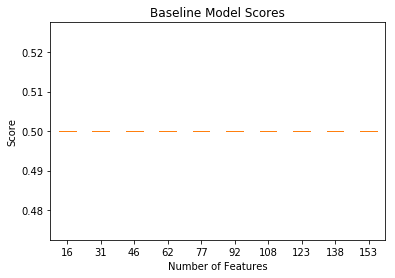

<Figure size 432x288 with 0 Axes>

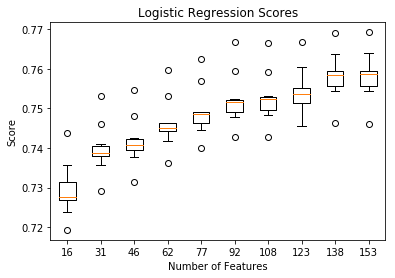

<Figure size 432x288 with 0 Axes>

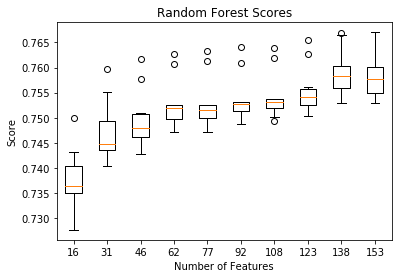

<Figure size 432x288 with 0 Axes>

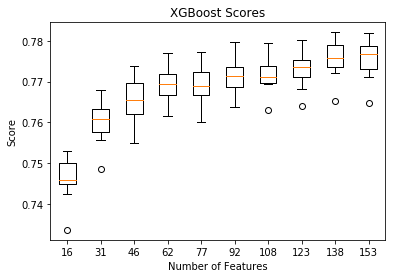

<Figure size 432x288 with 0 Axes>

In [28]:
# Check statistics on scores for the folds
# Baseline
plt.figure()
plt.title("Baseline Model Scores")
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.boxplot(baseline_scores, labels=number_of_features)
plt.show()
plt.savefig(log_path + '/baseline_scores_plot.png')

# Logistic Regression
plt.figure()
plt.title("Logistic Regression Scores")
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.boxplot(lr_scores, labels=number_of_features)
plt.show()
plt.savefig(log_path + '/lr_scores_plot.png')

# Random Forest
plt.figure()
plt.title("Random Forest Scores")
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.boxplot(rf_scores, labels=number_of_features)
plt.show()
plt.savefig(log_path + '/rf_scores_plot.png')

# XGBoost
plt.figure()
plt.title("XGBoost Scores")
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.boxplot(xgb_scores, labels=number_of_features)
plt.show()
plt.savefig(log_path + '/xgb_scores_plot.png')

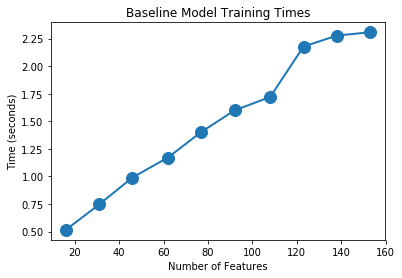

<Figure size 432x288 with 0 Axes>

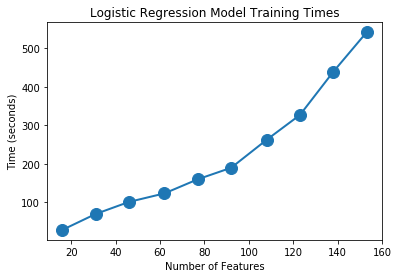

<Figure size 432x288 with 0 Axes>

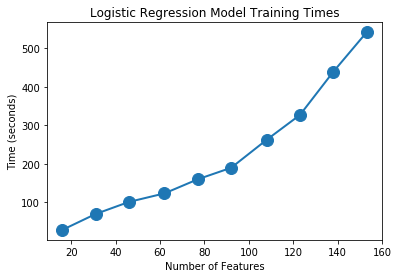

<Figure size 432x288 with 0 Axes>

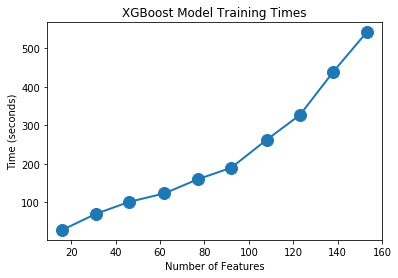

<Figure size 432x288 with 0 Axes>

In [29]:
# Baseline
plt.figure()
plt.title("Baseline Model Training Times")
plt.xlabel('Number of Features')
plt.ylabel('Time (seconds)')
plt.plot(number_of_features, baseline_training_times, marker='o', linewidth=2, markersize=12)
plt.show()
plt.savefig(log_path + '/baseline_times_plot.png')

# Logistic Regression
plt.figure()
plt.title("Logistic Regression Model Training Times")
plt.xlabel('Number of Features')
plt.ylabel('Time (seconds)')
plt.plot(number_of_features, lr_training_times, marker='o', linewidth=2, markersize=12)
plt.show()
plt.savefig(log_path + '/lr_times_plot.png')

# Random Forest
plt.figure()
plt.title("Logistic Regression Model Training Times")
plt.xlabel('Number of Features')
plt.ylabel('Time (seconds)')
plt.plot(number_of_features, lr_training_times, marker='o', linewidth=2, markersize=12)
plt.show()
plt.savefig(log_path + '/rf_times_plot.png')

# XGBoost
plt.figure()
plt.title("XGBoost Model Training Times")
plt.xlabel('Number of Features')
plt.ylabel('Time (seconds)')
plt.plot(number_of_features, lr_training_times, marker='o', linewidth=2, markersize=12)
plt.show()
plt.savefig(log_path + '/xgb_times_plot.png')

## Ensembling Models

<p>Now I will combine the models to check if any combination of the evaluated models will produce a better result then then models alone.</p>

First I will combine the three models (Linear Regression, Random Forest and XGBoost) then I will combine each two models.

In [30]:
start_time = time.time()

log("")
log("Ensembling Evaluated Methods")
log("----------------------------------------")


# Classifiers
logistic_regression = LogisticRegression(solver='saga', max_iter=4000)
random_forest = RandomForestClassifier()
random_forest.set_params(**rf_params)
xgboost_classifier = XGBClassifier()
xgboost_classifier.set_params(**xgb_params)

lr_rf_xgb_scores = list(range(10)) 
lr_rf_xgb_training_times = list(range(10)) 

lr_rf_scores = list(range(10)) 
lr_rf_training_times = list(range(10)) 

lr_xgb_scores = list(range(10)) 
lr_xgb_training_times = list(range(10)) 

rf_xgb_scores = list(range(10)) 
rf_xgb_training_times = list(range(10)) 


now = datetime.datetime.now()
log(now.strftime("%Y-%m-%d %H:%M:%S"))
iteration_time = time.time()

# The last step (10th) evaluated, with 153 features, will be used for the ensembling
last_feature_ind = 153
selected_features = X.columns[indices[:last_feature_ind]]
Xs = X[selected_features]

outer_cv = KFold(n_splits=10, shuffle=True, random_state=42)
    
# Logistic Regression, Random Forest and XGBoost
pre_train_time = time.time()
lr_rf_xgb = VotingClassifier(estimators=
                             [('lr', logistic_regression), ('rf', random_forest),('xgb', xgboost_classifier)], 
                             voting='soft', n_jobs=-1)
lr_rf_xgb_scores = cross_val_score(lr_rf_xgb, Xs, y, cv=outer_cv, scoring='roc_auc')
lr_rf_xgb_training_times = time.time() - pre_train_time
dumpToFile(lr_rf_xgb_scores, 'lr_rf_xgb_scores.dat')
log("Ensemble of LR, RF and XGBoost: mean: {:.5f}, min: {:.5f}, max: {:.5f}, std: {:.5f} (time {:.1f} secs)"
    .format(lr_rf_xgb_scores.mean(), lr_rf_xgb_scores.min(), 
                  lr_rf_xgb_scores.max(), lr_rf_xgb_scores.std(),
                  lr_rf_xgb_training_times))

# Logistic Regression and Random Forest
pre_train_time = time.time()
lr_rf = VotingClassifier(estimators=
                             [('lr', logistic_regression), ('rf', random_forest)], 
                             voting='soft', n_jobs=-1)
lr_rf_scores = cross_val_score(lr_rf, Xs, y, cv=outer_cv, scoring='roc_auc')
lr_rf_training_times = time.time() - pre_train_time
dumpToFile(lr_rf_scores, 'lr_rf_scores.dat')
log("Ensemble of LR and RF: mean: {:.5f}, min: {:.5f}, max: {:.5f}, std: {:.5f} (time {:.1f} secs)"
    .format(lr_rf_scores.mean(), lr_rf_scores.min(), 
                  lr_rf_scores.max(), lr_rf_scores.std(),
                  lr_rf_training_times))


# Logistic Regression and XGBoost
pre_train_time = time.time()
lr_xgb = VotingClassifier(estimators=
                             [('lr', logistic_regression), ('xgb', xgboost_classifier)], 
                             voting='soft', n_jobs=-1)
lr_xgb_scores = cross_val_score(lr_xgb, Xs, y, cv=outer_cv, scoring='roc_auc')
lr_xgb_training_times = time.time() - pre_train_time
dumpToFile(lr_xgb_scores, 'lr_xgb_scores.dat')
log("Ensemble of LR and XGBoost: mean: {:.5f}, min: {:.5f}, max: {:.5f}, std: {:.5f} (time {:.1f} secs)"
    .format(lr_xgb_scores.mean(), lr_xgb_scores.min(), 
                  lr_xgb_scores.max(), lr_xgb_scores.std(),
                  lr_xgb_training_times))

# Random Forest and XGBoost
pre_train_time = time.time()
rf_xgb = VotingClassifier(estimators=
                             [('rf', random_forest),('xgb', xgboost_classifier)], 
                             voting='soft', n_jobs=-1)
rf_xgb_scores = cross_val_score(rf_xgb, Xs, y, cv=outer_cv, scoring='roc_auc')
rf_xgb_training_times = time.time() - pre_train_time
dumpToFile(rf_xgb_scores, 'rf_xgb_scores.dat')
log("Ensemble RF and XGBoost: mean: {:.5f}, min: {:.5f}, max: {:.5f}, std: {:.5f} (time {:.1f} secs)"
    .format(rf_xgb_scores.mean(), rf_xgb_scores.min(), 
                  rf_xgb_scores.max(), rf_xgb_scores.std(),
                  rf_xgb_training_times))


log("Total Time: {:.1f} seconds".format(time.time() - start_time))
log("")




Ensembling Evaluated Methods
----------------------------------------
2019-10-25 20:10:42
Ensemble of LR, RF and XGBoost: mean: 0.77496, min: 0.76490, max: 0.78355, std: 0.00505 (time 4342.4 secs)
Ensemble of LR and RF: mean: 0.76734, min: 0.75788, max: 0.77748, std: 0.00512 (time 3672.0 secs)
Ensemble of LR and XGBoost: mean: 0.77492, min: 0.76334, max: 0.78357, std: 0.00544 (time 2315.6 secs)
Ensemble RF and XGBoost: mean: 0.77399, min: 0.76500, max: 0.78056, std: 0.00456 (time 4181.1 secs)
Total Time: 14511.4 seconds



7
7


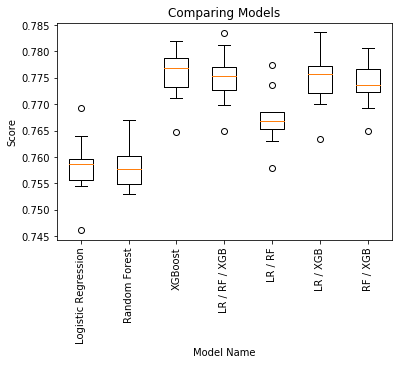

<Figure size 432x288 with 0 Axes>

In [44]:
if (  os.path.exists('data/final_lr_scores.dat') and
      os.path.exists('data/final_rf_scores.dat') and
      os.path.exists('data/final_xgb_scores.dat') and
      os.path.exists('data/lr_rf_xgb_scores.dat') and
      os.path.exists('data/lr_rf_scores.dat') and
      os.path.exists('data/lr_xgb_scores.dat') and
      os.path.exists('data/rf_xgb_scores.dat')  ):
    
    final_scores = list(range(7))
    final_scores[0] = loadFromFile('final_lr_scores.dat')
    final_scores[1] = loadFromFile('final_rf_scores.dat')
    final_scores[2] = loadFromFile('final_xgb_scores.dat')
    final_scores[3] = loadFromFile('lr_rf_xgb_scores.dat')
    final_scores[4] = loadFromFile('lr_rf_scores.dat')
    final_scores[5] = loadFromFile('lr_xgb_scores.dat')
    final_scores[6] = loadFromFile('rf_xgb_scores.dat')
    
    print(len(final_scores))
    
    model_names = ["Logistic Regression","Random Forest","XGBoost","LR / RF / XGB","LR / RF","LR / XGB","RF / XGB"]
    print(len(model_names))
    
    plt.figure()
    plt.title("Comparing Models")
    plt.xlabel('Model Name')
    plt.ylabel('Score')
    plt.boxplot(final_scores, labels=model_names)
    plt.xticks(rotation='vertical')
    plt.show()
    plt.savefig(log_path + '/rf_scores_plot.png')
else:
    print("Not all models were generated...")
    
    
    